# Table of Contents
 <p><div class="lev3"><a href="#lal-and-fft-functions-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>lal and fft functions</a></div><div class="lev4"><a href="#def-0.0.1.1"><span class="toc-item-num">0.0.1.1&nbsp;&nbsp;</span>def</a></div><div class="lev4"><a href="#examples-0.0.1.2"><span class="toc-item-num">0.0.1.2&nbsp;&nbsp;</span>examples</a></div><div class="lev2"><a href="#example-plot-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>example plot</a></div><div class="lev3"><a href="#compare-phenP-and-SEOBNRv3-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>compare phenP and SEOBNRv3</a></div><div class="lev2"><a href="#ifft-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>ifft</a></div><div class="lev3"><a href="#def-function-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>def function</a></div>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import phenom
import numpy as np

import lal
import lalsimulation as lalsim

In [3]:
import scipy
from scipy.fftpack import fft, fftfreq, fftshift, ifft

### lal and fft functions

#### def

In [4]:
def CallTDWaveform(approx, M, eta, 
                   chi1x, chi1y, chi1z,
                   chi2x, chi2y, chi2z, f_min=10, srate=2**14, f_ref=0.0, iota=0):
    """assuming m1>=m2"""
    deltaT=1./srate
    q = phenom.q_from_eta(eta)
    m1, m2 = phenom.m1_m2_M_eta(M, eta)
    m1_SI = m1 * lal.MSUN_SI
    m2_SI = m2 * lal.MSUN_SI
    # print 'chi_eff = ', (m1*chi1 + m2*chi2)/M
    # f_max_Hz = f_max / (M * lal.MTSUN_SI)
    phiRef = 0.0
    S1x = chi1x
    S1y = chi1y
    S1z = chi1z
    S2x = chi2x
    S2y = chi2y
    S2z = chi2z
    r = 1e6 * lal.PC_SI
    z = 0.0
    i = iota
    lambda1 = 0.0
    lambda2 = 0.0
    waveFlags = None
    nonGRparams = None
    amplitudeO = -1
    phaseO = -1
    # approximant = lalsim.GetApproximantFromString("IMRPhenomPv2")
    approximant = lalsim.GetApproximantFromString(approx)
    # print approximant
    hp, hc = lalsim.SimInspiralChooseTDWaveform(phiRef,
                                            deltaT,
                                            m1_SI, m2_SI,
                                            S1x, S1y, S1z, S2x, S2y, S2z,
                                            f_min, f_ref,
                                            r,
                                            i,
                                            lambda1, lambda2, waveFlags, nonGRparams,
                                            amplitudeO, phaseO,
                                            approximant)
    t = np.arange(hp.data.length) * hp.deltaT

    #convert to units of total mass (dimensionless)
    t = phenom.StoM(t, m1 + m2)
    
    return t, hp.data.data, hc.data.data

def CallFDWaveform(approx, M, eta,
                   chi1x, chi1y, chi1z,
                   chi2x, chi2y, chi2z, f_min=10, f_max=0, srate=2**14, f_ref=0.0, iota=0):
    """assuming m1>=m2"""
    deltaF=1./srate
    q = phenom.q_from_eta(eta)
    m1, m2 = phenom.m1_m2_M_eta(M, eta)
    m1_SI = m1 * lal.MSUN_SI
    m2_SI = m2 * lal.MSUN_SI
    # print 'chi_eff = ', (m1*chi1 + m2*chi2)/M
    # f_max_Hz = f_max / (M * lal.MTSUN_SI)
    phiRef = 0.0
    S1x = chi1x
    S1y = chi1y
    S1z = chi1z
    S2x = chi2x
    S2y = chi2y
    S2z = chi2z
    r = 1e6 * lal.PC_SI
    z = 0.0
    i = iota
    lambda1 = 0.0
    lambda2 = 0.0
    waveFlags = None
    nonGRparams = None
    amplitudeO = -1
    phaseO = -1
    # approximant = lalsim.GetApproximantFromString("IMRPhenomPv2")
    approximant = lalsim.GetApproximantFromString(approx)
    hp, hc = lalsim.SimInspiralChooseFDWaveform(phiRef,
                                            deltaF,
                                            m1_SI, m2_SI,
                                            S1x, S1y, S1z, S2x, S2y, S2z,
                                            f_min, f_max, f_ref,
                                            r,
                                            i,
                                            lambda1, lambda2, waveFlags, nonGRparams,
                                            amplitudeO, phaseO,
                                            approximant)
    f = np.arange(hp.data.length) * hp.deltaF
    
    #convert to units of total mass (dimensionless)
    f = phenom.HztoMf(f, m1 + m2)
    
    return f, hp.data.data, hc.data.data

In [5]:
from phenom.utils.utils import pad_to_pow_2

class WaveformTD(object):
    def __init__(self, t, hp, hc, mtot):
        
        self.mtot = mtot
        
        self.t = t
        self.hp = hp
        self.hc = hc
        
        self.dt = self.t[1] - self.t[0]
        
        self.amp = self.get_amp(self.hp, self.hc)
        self.peak_index = self.get_peak_index(self.hp, self.hc)
        self.tshifted = self.shift_times(self.t, self.hp, self.hc)
        self.phase = self.get_phase(self.hp, self.hc)
        
#         self.f, self.hptilde, self.hctilde = self.compute_fft(self.t, self.hp, self.hc, self.dt)
        self.f, self.hptilde, self.hctilde = self.compute_fft(self.tshifted, self.hp, self.hc, self.dt)
        
    def get_amp(self, hp, hc):
        return np.sqrt(hp**2. + hc**2.)
    
    def get_peak_index(self, hp, hc):
        amp = self.get_amp(hp, hc)
        max_amp_index = list(amp).index(max(amp))
        return max_amp_index
    
    def shift_times(self, t, hp, hc):
        max_amp_index = self.get_peak_index(hp, hc)
        return t - t[max_amp_index]
    
    def get_phase(self, hp, hc):
        return np.unwrap(np.angle(hp + 1.j * hc))
    
    def compute_fft(self, t, hp, hc, dt):
        
        ptaper_lower = phenom.planck_taper(t, t[0], t[0] + 1000.)
#         ptaper_lower = phenom.planck_taper(t, t[0], t[0] + 2.)
        hp = ptaper_lower * hp
        hc = ptaper_lower * hc
#         plt.plot(t, hp)
#         print("dt = {0}".format(dt))
        
#         t = pad_to_pow_2(t, 1)        
#         hp = pad_to_pow_2(hp, 1)
#         hc = pad_to_pow_2(hc, 1)
        
        
        N = len(t)
#         hptilde = scipy.fftpack.fft(hp) * dt / phenom.StoM(1., 100.)
#         hctilde = scipy.fftpack.fft(hc) * dt / phenom.StoM(1., 100.)
#FIXME SO I DONT HAVE TO PASS MTOT!!!
        hptilde = scipy.fftpack.fft(hp) * dt / phenom.StoM(1., self.mtot)
        hctilde = scipy.fftpack.fft(hc) * dt / phenom.StoM(1., self.mtot)

        f = scipy.fftpack.fftfreq(N, dt)
        
        mask = ( f > 0 )
        #return only positive frequencies
#         return f[0:N/2], hptilde[0:N/2], hctilde[0:N/2]

        #note that if the time domain waveform is in units of the total mass (M) then
        #we have to divide by the total mass in M

        return f[mask], hptilde[mask], hctilde[mask]

#### examples

In [6]:
t={}
hp={}
hc={}

In [7]:
f={}
hptilde={}
hctilde={}
f['phd'], hptilde['phd'], hctilde['phd'] = CallFDWaveform("IMRPhenomD", 100., 0.2222,
                                                          0., 0., 0.,
                                                          0., 0., 0.,
                                                          f_min=5., srate=10)

In [8]:
t['phd'], hp['phd'], hc['phd'] = CallTDWaveform("IMRPhenomD", 100., 0.2222,
                                                0., 0., 0.,
                                                0., 0., 0., f_min=5.)
t['v2'], hp['v2'], hc['v2'] = CallTDWaveform("SEOBNRv2", 100., 0.2222,
                                             0., 0., 0.,
                                             0., 0., 0., f_min=5.)

In [9]:
t['phpv2'], hp['phpv2'], hc['phpv2'] = CallTDWaveform("IMRPhenomPv2", 100., 0.2222,
                                                      0., 0., 0.8,
                                                      0., 0., 0.8, f_min=5.)
t['v3'], hp['v3'], hc['v3'] = CallTDWaveform("SEOBNRv3", 100., 0.2222,
                                             0., 0., 0.8,
                                             0., 0., 0.8, f_min=5., srate=2**13)

In [10]:
phend = WaveformTD(t['phd'], hp['phd'], hc['phd'], 100)
phpv2 = WaveformTD(t['phpv2'], hp['phpv2'], hc['phpv2'], 100)

v2 = WaveformTD(t['v2'], hp['v2'], hc['v2'], 100)
v3 = WaveformTD(t['v3'], hp['v3'], hc['v3'], 100)

/Users/sebastian/git/phenom/phenom/utils/utils.py:384: RuntimeWarning: overflow encountered in exp
  tout.append(1./(exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))


(-1000, 100)

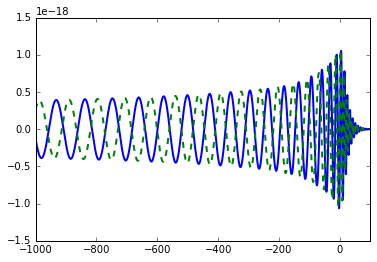

In [11]:
plt.plot(phpv2.tshifted, phpv2.hp, lw=2)
plt.plot(v3.tshifted, v3.hp, ls='--', lw=2)
plt.xlim(-1000,100)

(-100, 100)

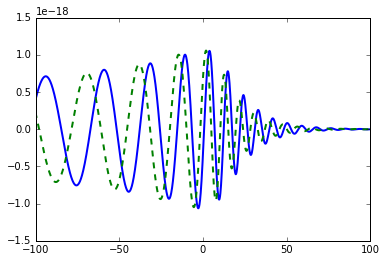

In [12]:
plt.plot(phpv2.tshifted, phpv2.hp, lw=2)
plt.plot(v3.tshifted, v3.hp, ls='--', lw=2)
plt.xlim(-100,100)

(1e-24, 1e-18)

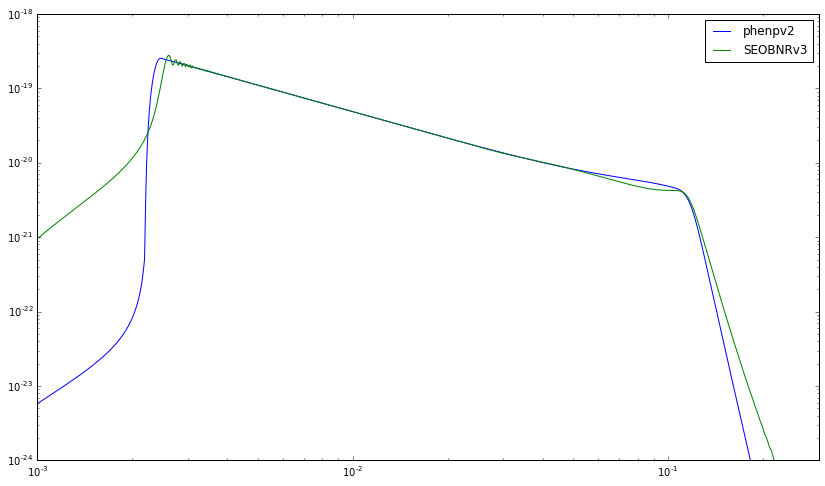

In [13]:
plt.figure( figsize=(14,8) )
plt.plot(phpv2.f, np.abs(phpv2.hptilde), label='phenpv2')
plt.plot(v3.f, np.abs(v3.hptilde), label='SEOBNRv3')
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.001,0.3)
plt.ylim(1e-24, 1e-18)

## example plot

### compare phenP and SEOBNRv3

In [15]:
#interpolate new phenomP coeffs

In [16]:
phenompv3 = phenom.Waveform(approximant="IMRPhenomPv3")
from copy import copy
phenpv3_1 = copy(phenompv3)

In [156]:
m1=80.4782639
m2=16.384655
# delta_f=1.0/64
delta_f=1.0/128
# delta_f=1.0/256
f_min=5.
# f_min=5.
# f_min=1.
chi1x = 0.062809065
chi1y=0.528722703
chi1z=-0.77006942
chi2x=-0.102698207
chi2y=-0.0977499112
chi2z=-0.0815029368
# inc=2.85646439
inc=0.
# f_ref = f_min
# f_ref = 30

M, eta = phenom.M_eta_m1_m2(m1, m2)

In [157]:
m2=75.
chi1x = 0.0
chi1y=0.
chi1z=0.
chi2x=0.
chi2y=0.
chi2z=0

In [158]:
# m1=50.
# # m2=20.
# m2=50./2.
# chi1x=0.3
# chi1y=0.
# chi1z=0.
# chi2x=0.
# chi2y=0.
# chi2z=0.
# delta_f=1/64.
# # delta_f=1/128.
# # delta_f=1/512.
# f_min=5.
# # inc=0.
# inc=np.pi/3.
# f_ref = 5.

# M, eta = phenom.M_eta_m1_m2(m1, m2)

In [159]:
phenpv3_1.input_params['m1']=m1
phenpv3_1.input_params['m2']=m2
phenpv3_1.input_params['chi1x']=chi1x
phenpv3_1.input_params['chi1y']=chi1y
phenpv3_1.input_params['chi1z']=chi1z
phenpv3_1.input_params['chi2x']=chi2x
phenpv3_1.input_params['chi2y']=chi2y
phenpv3_1.input_params['chi2z']=chi2z
phenpv3_1.input_params['inclination']=inc
phenpv3_1.input_params['f_min']=f_min
phenpv3_1.input_params['delta_f']=delta_f
phenpv3_1.input_params['fRef']=f_ref

In [142]:
#phenomp_v3 waveform generator
phenpv3_1.phenompv3(phenpv3_1.input_params)

In [160]:
ph_phpLAL = phenom.Waveform(approximant='IMRPhenomPv2_LAL',m1=m1, m2=m2,
                            chi1x=chi1x, chi1y=chi1y, chi1z=chi1z,
                            chi2x=chi2x, chi2y=chi2y, chi2z=chi2z,
                            delta_f=delta_f, f_min=f_min, fRef=f_ref,
                            inclination=inc)

In [164]:
t={}
hp={}
hc={}
t['v3'], hp['v3'], hc['v3'] = CallTDWaveform("SEOBNRv3", M, eta,
                                             chi1x, chi1y, chi1z,
                                             chi2x, chi2y, chi2z,
                                             f_min=f_min,
                                             srate=2**10,
                                             iota=inc+0.4,
                                             f_ref=f_ref)

In [165]:
v3 = WaveformTD(t['v3'], hp['v3'], hc['v3'], M)

(1e-24, 1e-16)

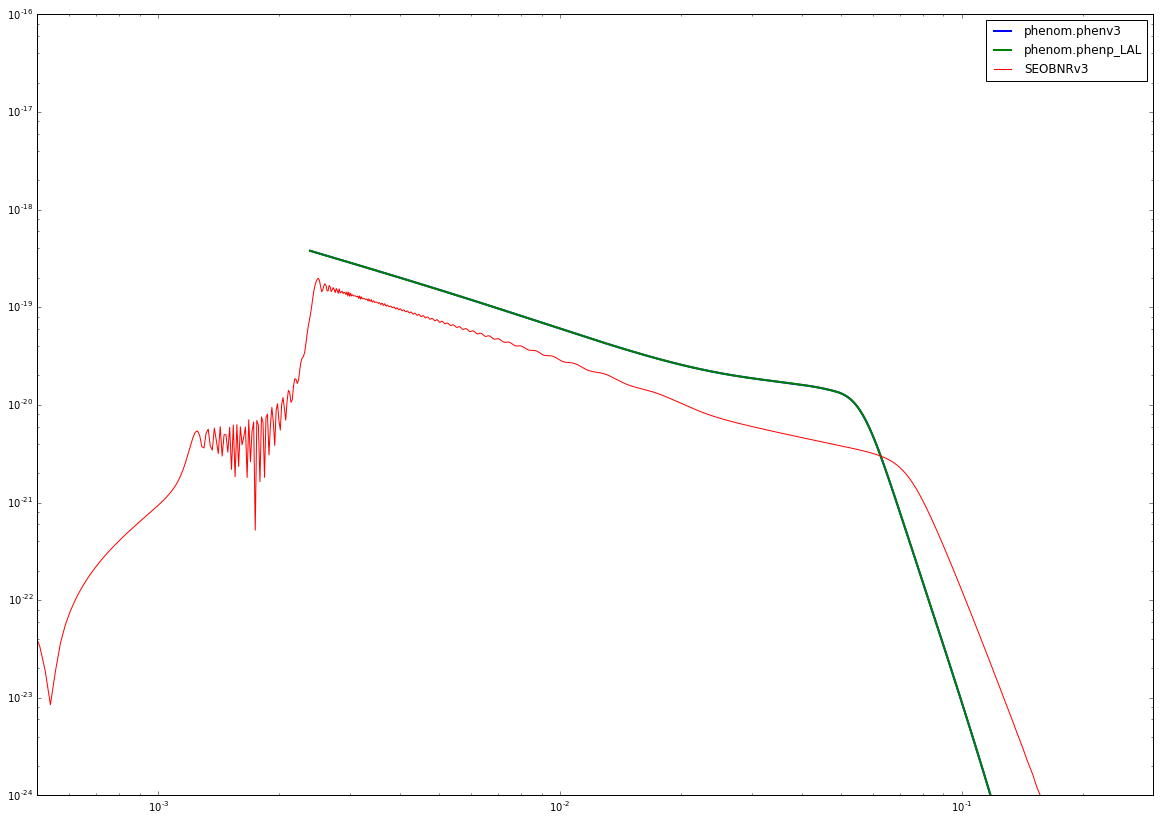

In [166]:
plt.figure( figsize=(20,14) )
plt.plot( phenom.HztoMf(phenpv3_1.flist_Hz, M), np.absolute(phenpv3_1.hptilde), label='phenom.phenv3', lw=2)
plt.plot( phenom.HztoMf(ph_phpLAL.flist_Hz, M), np.absolute(ph_phpLAL.hptilde), label='phenom.phenp_LAL', lw=2)
plt.plot(v3.f, np.abs(v3.hptilde), label='SEOBNRv3')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlim(0.0005,0.3)
plt.ylim(1e-24, 1e-16)

## ifft

### def function

In [41]:
def invfft2(f, htilde, flow, dt):
    phase = np.unwrap(np.angle(htilde))
    
    phase_shift = (phase[0] - phase[-1])/2.

    dfMax=np.pi / (phase[0] - phase_shift )
    
    df=np.abs(dfMax / 2.)

    
    htilde = htilde * np.exp( -1.j * phase_shift * f)
    
    
    nPts = np.ceil(1. / (df * dt))
    
    
    totT=nPts * dt
    df=1./totT
    fmax = 1./(2. *  dt)
    
#     ptaper_lower = phenom.planck_taper(f, f[0], f[0] + 1.)
    ptaper_lower = phenom.planck_taper(f, f[0], f[0] + 5.)
    htilde_taper = ptaper_lower * htilde

#     plt.figure()
#     plt.plot(f, np.abs(htilde))
#     plt.plot(f, np.abs(htilde_taper))
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.ylim(1e-27, 1e-17)
    
    td = ifft(htilde_taper) * df
    
#     plt.figure()
#     plt.plot(np.real(td))
    
    times = np.linspace( 0., totT, len(td) )
#     times = np.arange( 0., totT, 0.1239 )
    
    return times, td

In [84]:
times, td = invfft2( ph_phpLAL.flist_Hz, ph_phpLAL.hptilde + 1.j * ph_phpLAL.hctilde, 0 , 0.1 )

In [85]:
times_p3, td_p3 = invfft2( phenpv3_1.flist_Hz, phenpv3_1.hptilde + 1.j * phenpv3_1.hctilde, 0 , 0.1 )

In [59]:
# ifft SEOBNRv3 doesn't work right now. But lets just use the TimeDomain from LAL
# times, td = invfft2( phenom.MftoHz( v3.f, M ), v3.hptilde - 1.j * v3.hctilde, 0 , 0.1 )

(-0.1, 0.1)

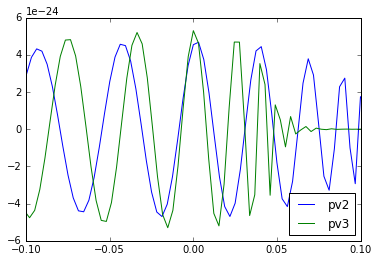

In [86]:
maxindex = list(np.abs(td)).index(np.max(np.abs(td)))
plt.plot(times - times[maxindex], np.real(td), label='pv2')

maxindex = list(np.abs(td_p3)).index(np.max(np.abs(td_p3)))
plt.plot(times_p3 - times_p3[maxindex], np.real(td_p3), label='pv3')



plt.legend(loc='best')
# plt.xlim(-1,1)
plt.xlim(-0.1,0.1)
# plt.xlim(-2,1)
# plt.xlim(-30,3)

(-0.3, 0.3)

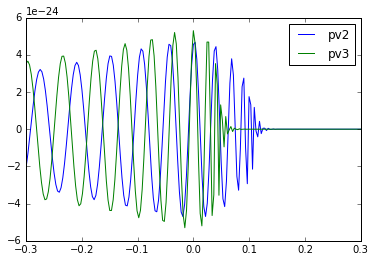

In [89]:
maxindex = list(np.abs(td)).index(np.max(np.abs(td)))
plt.plot(times - times[maxindex], np.real(td), label='pv2')

maxindex = list(np.abs(td_p3)).index(np.max(np.abs(td_p3)))
plt.plot(times_p3 - times_p3[maxindex], np.real(td_p3), label='pv3')



plt.legend(loc='best')
# plt.xlim(-1,1)
# plt.xlim(-0.03,0.03)
plt.xlim(-0.3,0.3)
# plt.xlim(-2,1)
# plt.xlim(-30,3)

(-1, 1)

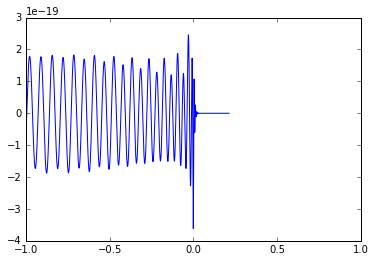

In [91]:
# plt.plot(  phenom.MtoS( v3.tshifted, M ), v3.hp / 100000, label='EOBv3')
plt.plot( phenom.MtoS( v3.tshifted, M ), v3.hp, label='EOBv3')
plt.xlim(-1,1)